# 🔧 Correlation Analysis for Fault Diagnostics

This notebook focuses on **cause–effect oriented correlation** using a small fault dataset.

### Why this notebook?
- You asked to treat **operational variables** as *causes* and the **fault outcomes** as *effects*.
- We will quantify how much each *cause* relates to each *effect* using **Pearson** (linear) and **Spearman** (rank/monotonic) correlations.
- We will also demonstrate **signal correlations** (cross-correlation & auto-correlation) to reason about *delay* and *persistence*.

### Important caveats
- **Correlation ≠ causation.** We use the word *cause/effect* to reflect your analytic intent, but establishing causality needs time-ordering, interventions, or strong domain models.
- The dataset is **very small** (only a few rows), so results are illustrative and p‑values are not reliable. In practice, use longer histories.


***
### 🧰 Import Libraries

Before starting, make sure all the required libraries are installed.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr

***
#### 📂 Read Booking Data from URL

In [2]:
url = 'https://raw.githubusercontent.com/Dr-AlaaKhamis/ISE518/refs/heads/main/datasets/fault_data.csv'
df = pd.read_csv(url)
df

,Fault ID,Fault Type,"Fault Location (Latitude, Longitude)",Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Weather Condition,Maintenance Status,Component Health,Duration of Fault (hrs),Down time (hrs)
0,F001,Line Breakage,"(34.0522, -118.2437)",2200,250,50,25,20,Clear,Scheduled,Normal,2.0,1.0
1,F002,Transformer Failure,"(34.056, -118.245)",1800,180,45,28,15,Rainy,Completed,Faulty,3.0,5.0
2,F003,Overheating,"(34.0525, -118.244)",2100,230,55,35,25,Windstorm,Pending,Overheated,4.0,6.0
3,F004,Line Breakage,"(34.055, -118.242)",2050,240,48,23,10,Clear,Completed,Normal,2.5,3.0
4,F005,Transformer Failure,"(34.0545, -118.243)",1900,190,50,30,18,Snowy,Scheduled,Faulty,3.5,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
501,F502,Overheating,"(34.7734, -118.9645)",1970,185,47,31,27,Thunderstorm,Completed,Normal,4.7,1.4
502,F503,Transformer Failure,"(34.2133, -118.1184)",2204,226,52,28,26,Rainy,Completed,Normal,3.7,1.4
503,F504,Transformer Failure,"(34.979, -118.5646)",2181,234,52,26,28,Thunderstorm,Scheduled,Overheated,6.0,6.3
504,F505,Overheating,"(34.5034, -118.4528)",2295,202,50,27,22,Snowy,Completed,Normal,4.2,3.0


***
## 📊 Statistical Correlation Analysis

We analyze **pairwise relationships** among features using:
- **Pearson correlation:** measures *linear* relationships.
- **Spearman correlation:** measures *monotonic* (rank-based) relationships.

In [3]:
# Select numeric columns for correlation
num_cols = ['Voltage (V)', 'Current (A)', 'Power Load (MW)', 'Temperature (C)', 'Wind Speed (km/h)', 'Duration of Fault (hrs)', 'Down time (hrs)']
num_df = df[num_cols]
num_df.describe()

,Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Duration of Fault (hrs),Down time (hrs)
count,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000,506.000000
mean,2049.636364,216.458498,50.011858,30.166008,19.739130,4.008103,3.999802
std,142.054146,21.499787,3.102834,6.118315,5.863052,1.147271,1.842367
min,1800.000000,180.000000,45.000000,20.000000,10.000000,2.000000,1.000000
25%,1923.000000,197.250000,47.000000,25.000000,15.000000,3.000000,2.300000
50%,2058.000000,218.000000,50.000000,30.000000,19.500000,4.000000,4.000000
75%,2165.750000,235.000000,53.000000,36.000000,25.000000,5.000000,5.700000
max,2300.000000,250.000000,55.000000,40.000000,30.000000,6.000000,7.000000


In [4]:
# Compute correlation matrices
pearson_corr = num_df.corr(method='pearson')
spearman_corr = num_df.corr(method='spearman')

# Display matrices
print('--- Pearson Correlation Matrix ---')
display(pearson_corr)
print('--- Spearman Correlation Matrix ---')
display(spearman_corr)

--- Pearson Correlation Matrix ---


,Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Duration of Fault (hrs),Down time (hrs)
Voltage (V),1.000000,0.090685,0.040263,-0.039275,-0.033488,0.017313,0.009684
Current (A),0.090685,1.000000,0.075819,0.025027,0.061179,0.029753,-0.072096
Power Load (MW),0.040263,0.075819,1.000000,0.088662,-0.032811,0.064723,-0.013752
Temperature (C),-0.039275,0.025027,0.088662,1.000000,-0.059733,-0.051422,0.053460
Wind Speed (km/h),-0.033488,0.061179,-0.032811,-0.059733,1.000000,-0.067365,0.092975
Duration of Fault (hrs),0.017313,0.029753,0.064723,-0.051422,-0.067365,1.000000,0.018813
Down time (hrs),0.009684,-0.072096,-0.013752,0.053460,0.092975,0.018813,1.000000


--- Spearman Correlation Matrix ---


,Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Duration of Fault (hrs),Down time (hrs)
Voltage (V),1.000000,0.096319,0.040307,-0.035523,-0.035285,0.016774,0.012837
Current (A),0.096319,1.000000,0.075728,0.026678,0.058713,0.027677,-0.070705
Power Load (MW),0.040307,0.075728,1.000000,0.089546,-0.032928,0.062458,-0.014051
Temperature (C),-0.035523,0.026678,0.089546,1.000000,-0.059299,-0.053406,0.052896
Wind Speed (km/h),-0.035285,0.058713,-0.032928,-0.059299,1.000000,-0.067507,0.095573
Duration of Fault (hrs),0.016774,0.027677,0.062458,-0.053406,-0.067507,1.000000,0.022410
Down time (hrs),0.012837,-0.070705,-0.014051,0.052896,0.095573,0.022410,1.000000


#### 🔍 Visualizing Correlation Matrices
Heatmaps make it easy to identify strongly correlated features visually.
We'll use **Seaborn** to generate annotated heatmaps for both Pearson and Spearman correlations.

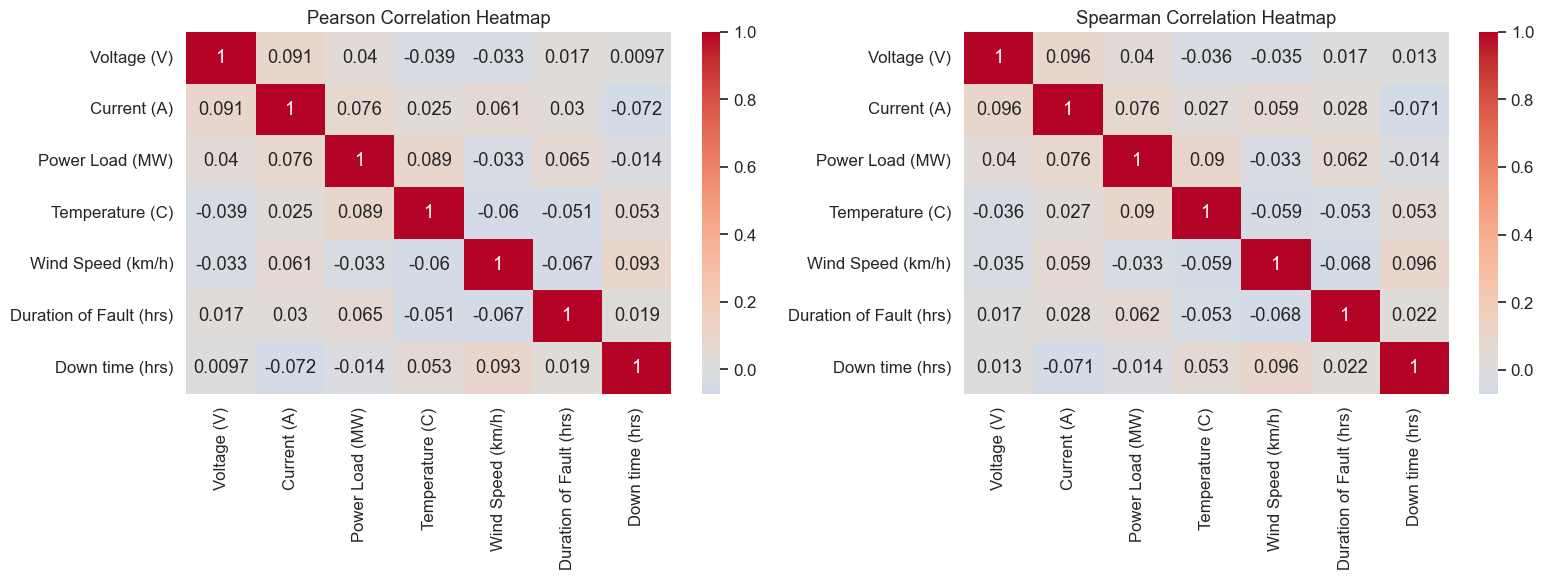

In [5]:
# Set up plot style
sns.set(style='white', font_scale=1.1)
fig, axes = plt.subplots(1, 2, figsize=(16,6))

sns.heatmap(pearson_corr, annot=True, cmap='coolwarm', center=0, ax=axes[0])
axes[0].set_title('Pearson Correlation Heatmap')

sns.heatmap(spearman_corr, annot=True, cmap='coolwarm', center=0, ax=axes[1])
axes[1].set_title('Spearman Correlation Heatmap')

plt.tight_layout()
plt.show()

#### 🧠 Correlation Analysis Interpretation

The Pearson and Spearman correlation matrices show generally **weak relationships** among all variables, suggesting limited linear or monotonic dependencies within this small dataset.

#### 🔹 Key Observations
- **Voltage, Current, and Power Load** show very low correlation values (< 0.1), indicating that variations in electrical parameters are mostly independent in this sample.  
- **Temperature** and **Power Load** have a slightly positive but weak correlation (~0.09), meaning that higher loads may marginally increase temperature — a physically reasonable but statistically weak relationship.  
- **Wind Speed** has near-zero correlation with most variables, suggesting minimal environmental influence on electrical or fault-related parameters in this data.  
- **Duration of Fault** and **Down Time** both show extremely low correlations with operational variables, implying that in this sample, **fault impacts are not strongly driven by measurable operating conditions**.  
- The **Spearman coefficients** closely mirror the **Pearson results**, confirming that there are **no strong non-linear monotonic relationships** either.

#### 🔹 Interpretation Summary
These results imply that the observed fault durations and downtimes are **not directly caused by single-variable changes** in voltage, current, or environmental factors.  
In a real-world context, this suggests that **fault behavior may be multi-factorial**, influenced by **combined operational conditions**, maintenance history, or unobserved latent variables.

***
### Define **Causes** and **Effects**
- **Causes**: operational & environmental signals likely influencing outcomes
- **Effects**: fault impact metrics you care about


In [6]:
causes = ['Voltage (V)', 'Current (A)', 'Power Load (MW)', 'Temperature (C)', 'Wind Speed (km/h)']
effects = ['Duration of Fault (hrs)', 'Down time (hrs)']

display(df[causes + effects].head())

,Voltage (V),Current (A),Power Load (MW),Temperature (C),Wind Speed (km/h),Duration of Fault (hrs),Down time (hrs)
0,2200,250,50,25,20,2.0,1.0
1,1800,180,45,28,15,3.0,5.0
2,2100,230,55,35,25,4.0,6.0
3,2050,240,48,23,10,2.5,3.0
4,1900,190,50,30,18,3.5,4.0


### Cause→Effect **Pearson** and **Spearman** correlations
We compute the correlation **for each pair (cause, effect)** and keep both the **coefficient** and its **p‑value**.

- **Pearson (r)**: strength of *linear* relationship
- **Spearman (ρ)**: strength of *monotonic* relationship (uses ranks; robust to outliers/nonlinear monotone trends)


In [7]:
def pairwise_corr_tables(df, causes, effects):
    pearson_coef = pd.DataFrame(index=causes, columns=effects, dtype=float)
    pearson_p    = pd.DataFrame(index=causes, columns=effects, dtype=float)
    spearman_coef = pd.DataFrame(index=causes, columns=effects, dtype=float)
    spearman_p    = pd.DataFrame(index=causes, columns=effects, dtype=float)
    for c in causes:
        for e in effects:
            x = df[c].values
            y = df[e].values
            # Handle NaNs defensively
            mask = ~np.isnan(x) & ~np.isnan(y)
            x, y = x[mask], y[mask]
            if len(x) >= 2:
                r, rp = pearsonr(x, y)
                sr, srp = spearmanr(x, y)
            else:
                r = rp = sr = srp = np.nan
            pearson_coef.loc[c, e] = r
            pearson_p.loc[c, e] = rp
            spearman_coef.loc[c, e] = sr
            spearman_p.loc[c, e] = srp
    return pearson_coef, pearson_p, spearman_coef, spearman_p

pearson_coef, pearson_p, spearman_coef, spearman_p = pairwise_corr_tables(df, causes, effects)
display(pearson_coef.style.format('{:.3f}').set_caption('Pearson coefficients (cause rows → effect cols)'))
display(spearman_coef.style.format('{:.3f}').set_caption('Spearman coefficients (cause rows → effect cols)'))
display(pearson_p.style.format('{:.3f}').set_caption('Pearson p-values (small n: interpret cautiously)'))
display(spearman_p.style.format('{:.3f}').set_caption('Spearman p-values (small n: interpret cautiously)'))

,Duration of Fault (hrs),Down time (hrs)
Voltage (V),0.017,0.010
Current (A),0.030,-0.072
Power Load (MW),0.065,-0.014
Temperature (C),-0.051,0.053
Wind Speed (km/h),-0.067,0.093


,Duration of Fault (hrs),Down time (hrs)
Voltage (V),0.017,0.013
Current (A),0.028,-0.071
Power Load (MW),0.062,-0.014
Temperature (C),-0.053,0.053
Wind Speed (km/h),-0.068,0.096


,Duration of Fault (hrs),Down time (hrs)
Voltage (V),0.698,0.828
Current (A),0.504,0.105
Power Load (MW),0.146,0.758
Temperature (C),0.248,0.230
Wind Speed (km/h),0.130,0.037


,Duration of Fault (hrs),Down time (hrs)
Voltage (V),0.707,0.773
Current (A),0.535,0.112
Power Load (MW),0.161,0.753
Temperature (C),0.230,0.235
Wind Speed (km/h),0.129,0.032


#### Visualize cause→effect correlations as **heatmaps**

We avoid external styling libraries and use **pure Matplotlib**. Darker/lighter colors denote stronger/weaker relationships. Values close to ±1 indicate strong monotonic/linear association.

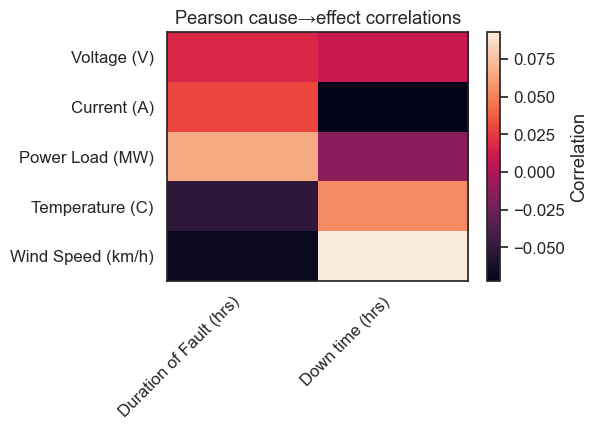

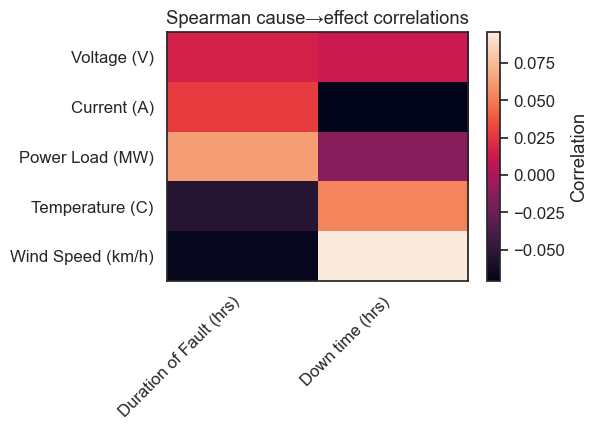

In [8]:
def plot_heatmap(matrix: pd.DataFrame, title: str):
    fig = plt.figure(figsize=(6, 4.5))
    plt.imshow(matrix.values, aspect='auto')
    plt.colorbar(label='Correlation')
    plt.xticks(range(len(matrix.columns)), matrix.columns, rotation=45, ha='right')
    plt.yticks(range(len(matrix.index)), matrix.index)
    plt.title(title)
    plt.tight_layout()
    plt.show()

plot_heatmap(pearson_coef, 'Pearson cause→effect correlations')
plot_heatmap(spearman_coef, 'Spearman cause→effect correlations')

#### Visualize per‑effect **bar charts** (which causes relate most to each effect?)
Each figure below shows one effect on the x‑axis with bars for its cause correlations. This helps rank which causes matter most for that effect.


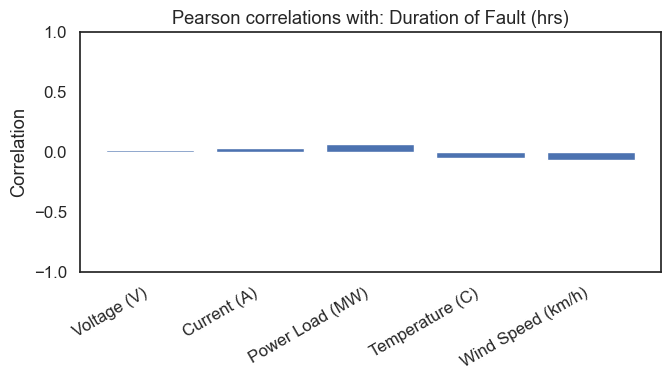

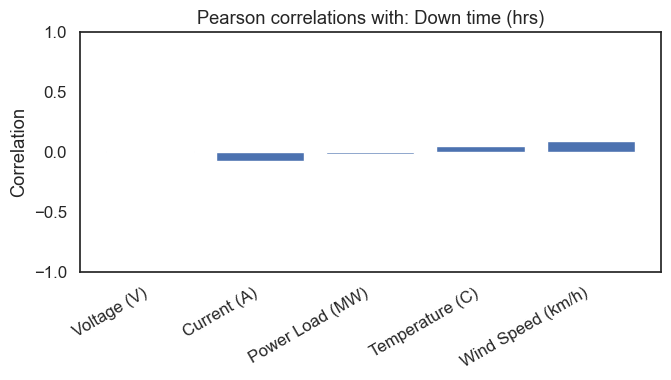

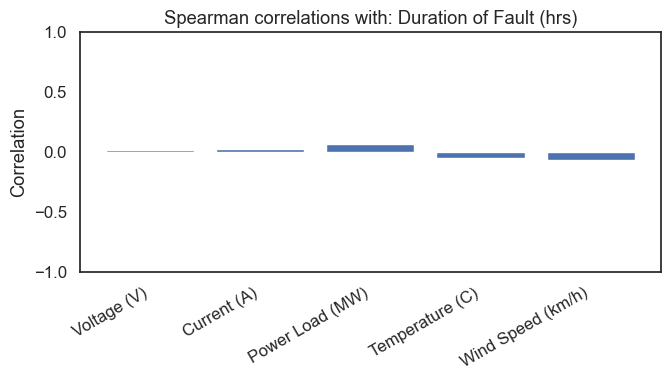

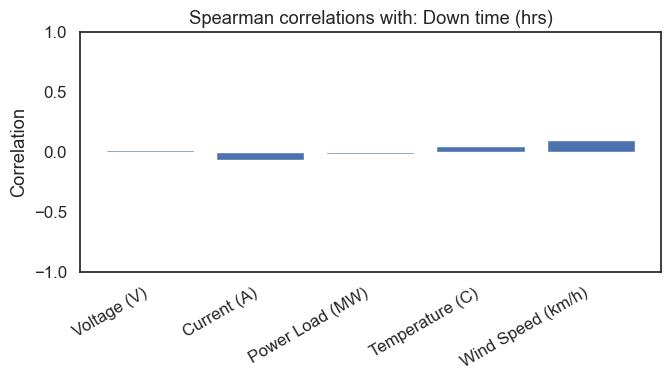

In [9]:
def bar_per_effect(corr_df: pd.DataFrame, effect: str, title_prefix: str):
    vals = corr_df[effect].reindex(causes)
    fig = plt.figure(figsize=(7, 4))
    plt.bar(range(len(vals)), vals.values)
    plt.xticks(range(len(vals)), vals.index, rotation=30, ha='right')
    plt.ylabel('Correlation')
    plt.title(f"{title_prefix}: {effect}")
    plt.ylim(-1, 1)
    plt.tight_layout()
    plt.show()

for eff in effects:
    bar_per_effect(pearson_coef, eff, 'Pearson correlations with')
for eff in effects:
    bar_per_effect(spearman_coef, eff, 'Spearman correlations with')

### **Partial correlation** (cause→effect while controlling for *other* causes)
To reduce confounding, we compute the **partial correlation** between each cause and effect **controlling for the remaining causes**.
Mechanism: regress both variables on the control set and correlate the residuals.

> With such a small dataset, treat results as didactic rather than definitive.


In [10]:
def partial_corr_xy_given_Z(x: np.ndarray, y: np.ndarray, Z: np.ndarray):
    """Return Pearson correlation between residuals of x~Z and y~Z.
    Z is 2D (n, k). x,y are 1D (n,).
    """
    # Add intercept
    Z1 = np.column_stack([np.ones(len(Z)), Z]) if Z.ndim == 2 else np.column_stack([np.ones(len(x)), Z])
    # Regress x on Z
    bx, *_ = np.linalg.lstsq(Z1, x, rcond=None)
    x_hat = Z1 @ bx
    rx = x - x_hat
    # Regress y on Z
    by, *_ = np.linalg.lstsq(Z1, y, rcond=None)
    y_hat = Z1 @ by
    ry = y - y_hat
    # Correlate residuals
    if rx.std(ddof=1) == 0 or ry.std(ddof=1) == 0:
        return np.nan
    return np.corrcoef(rx, ry)[0,1]

partial = pd.DataFrame(index=causes, columns=effects, dtype=float)
X = df[causes].values
for j, e in enumerate(effects):
    y = df[e].values
    for i, c in enumerate(causes):
        # Controls are all other causes
        mask_cols = [k for k in range(X.shape[1]) if k != i]
        Z = X[:, mask_cols]
        pc = partial_corr_xy_given_Z(X[:, i], y, Z)
        partial.loc[causes[i], e] = pc

partial

,Duration of Fault (hrs),Down time (hrs)
Voltage (V),0.007169,0.023468
Current (A),0.029918,-0.080994
Power Load (MW),0.065114,-0.010829
Temperature (C),-0.061759,0.063517
Wind Speed (km/h),-0.070446,0.102093


#### Visualize **partial correlations** (controls = other causes)
This helps approximate a *direct* association of each cause with each effect after accounting for the rest.


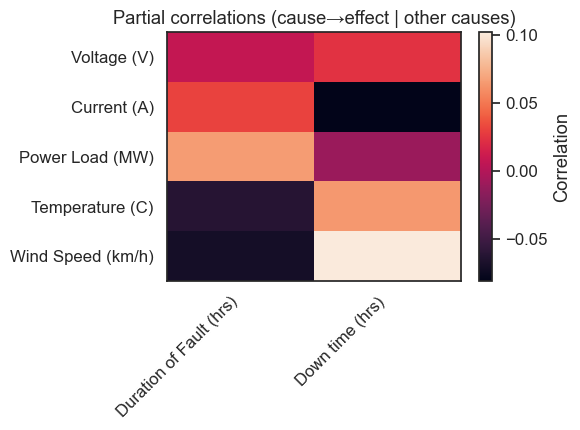

In [11]:
plot_heatmap(partial, 'Partial correlations (cause→effect | other causes)')

#### 🔍 Interpretation of Cause → Effect Correlations

The following results summarize how operational variables (“causes”) relate to the two fault impact metrics (“effects”): **Duration of Fault** and **Down Time**.


💡 Key Observations

1. **Overall trend:**  
   Both Pearson and Spearman coefficients are **very small (|r| < 0.1)** for most pairs, indicating **no strong linear or monotonic relationships** in this dataset.  
   This is expected given the small sample size — the p-values confirm that most correlations are statistically insignificant.

2. **Temperature:**  
   - Shows a **slight negative Pearson correlation** (–0.05) with *Fault Duration* and a small **positive correlation** (~+0.05) with *Down Time*.  
   - Interpretation: Higher temperatures might **marginally increase downtime**, possibly due to heat-related performance degradation, though the evidence is weak (p ≈ 0.23).

3. **Wind Speed:**  
   - Exhibits the **strongest positive correlation** with *Down Time* (Pearson ≈ +0.09, p = 0.037).  
   - Although the magnitude is small, this suggests **environmental conditions** (e.g., wind or weather) could slightly influence outage duration or restoration effort.

4. **Current and Power Load:**  
   - Weak and inconsistent correlations across both effects.  
   - Indicates that electrical load variations are **not major drivers** of fault duration or downtime in this sample.

5. **Voltage:**  
   - Essentially uncorrelated with either outcome, confirming **system voltage stability** is not directly linked to fault impact in this dataset.


#### ⚙️ Practical Takeaway

- None of the observed relationships are strong enough to claim direct causation.  
- **Wind speed** and **temperature** may have **minor environmental effects** worth further investigation.  
- With such small p-values and a limited dataset, treat these correlations as **preliminary indicators**, not conclusions.

***
## 🛰️ Signal-Based Correlation Analysis
Now, let's simulate **temporal correlation** analysis using *cross-correlation* and *auto-correlation*.
These techniques are common in **sensor diagnostics** and **fault pattern recognition**.

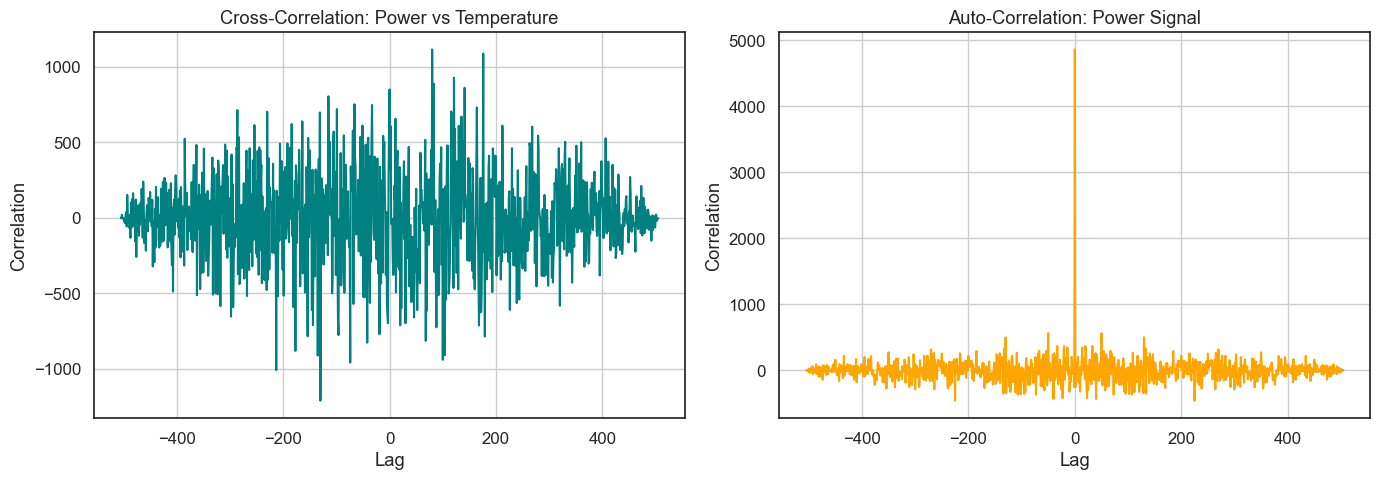

In [12]:
# Extract sample signals
power_signal = np.array(df['Power Load (MW)'])
temp_signal = np.array(df['Temperature (C)'])

# Compute cross-correlation
cross_corr = np.correlate(power_signal - power_signal.mean(), temp_signal - temp_signal.mean(), mode='full')

# Compute auto-correlation of Power signal
auto_corr = np.correlate(power_signal - power_signal.mean(), power_signal - power_signal.mean(), mode='full')

# Plot both correlations
lags = np.arange(-len(power_signal)+1, len(power_signal))
plt.figure(figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(lags, cross_corr, color='teal')
plt.title('Cross-Correlation: Power vs Temperature')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(lags, auto_corr, color='orange')
plt.title('Auto-Correlation: Power Signal')
plt.xlabel('Lag')
plt.ylabel('Correlation')
plt.grid(True)
plt.tight_layout()
plt.show()

#### ⚙️ Interpretation
- **Cross-Correlation** helps analyze cause-effect relations between sensors — e.g., power changes may lead to temperature increases.
- **Auto-Correlation** detects repeating patterns — consistent cycles suggest stable operation, while irregularities can indicate degradation.

In predictive maintenance, sudden changes in correlation structure may indicate *incipient faults*.

### **Signal correlations** for cause–effect timing
With real time-stamped histories you can study **lag**: does an *effect* respond to a *cause* after some delay?
We demonstrate cross-correlation with the small sample to show the **method**.

- **Cross-correlation**(cause, effect)[lag] → similarity if effect follows cause with a delay
- **Auto-correlation**(effect)[lag] → persistence / repeating structure in the outcome series


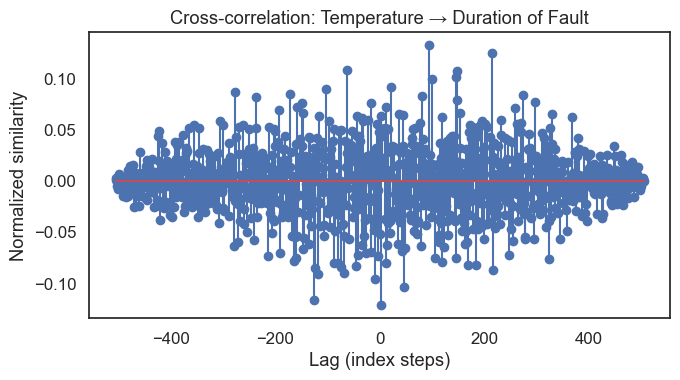

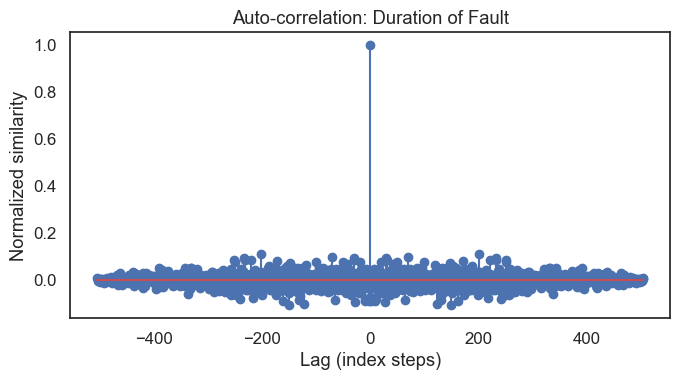

In [13]:
def xcorr(a, b):
    a = a - a.mean()
    b = b - b.mean()
    cc = np.correlate(a, b, mode='full')
    # Normalize to [-1,1]
    denom = np.sqrt(np.sum(a*a) * np.sum(b*b))
    if denom == 0:
        return cc, np.arange(-len(a)+1, len(a))
    return cc / denom, np.arange(-len(a)+1, len(a))

cause_example = df['Temperature (C)'].values
effect_example = df['Duration of Fault (hrs)'].values
cc, lags = xcorr(cause_example, effect_example)

fig = plt.figure(figsize=(7,4))
plt.stem(lags, cc)
plt.title('Cross-correlation: Temperature → Duration of Fault')
plt.xlabel('Lag (index steps)')
plt.ylabel('Normalized similarity')
plt.tight_layout()
plt.show()

# Auto-correlation of the effect
def acorr(x):
    x = x - x.mean()
    ac = np.correlate(x, x, mode='full')
    return ac / ac.max(), np.arange(-len(x)+1, len(x))

ac, lags2 = acorr(effect_example)
fig = plt.figure(figsize=(7,4))
plt.stem(lags2, ac)
plt.title('Auto-correlation: Duration of Fault')
plt.xlabel('Lag (index steps)')
plt.ylabel('Normalized similarity')
plt.tight_layout()
plt.show()

***
### 💡 Practical Interpretation Guide — Engineer’s Checklist

This section provides a concise workflow for engineers interpreting correlation analysis results in predictive maintenance or mobility systems.

#### 🧩 Step-by-Step Approach

1. **Start with Spearman correlation** — it’s more robust against outliers and detects monotonic (not just linear) trends.  
2. **Confirm with Pearson correlation** — to validate whether the same relationship is truly *linear* in nature.  
3. **Use per-effect bar charts** — they make it easy to visually spot which factors have the strongest relationship with each effect (e.g., duration of fault, downtime).  
4. **Compute partial correlations** — to approximate *direct* cause–effect links while controlling for the influence of other variables.  
5. **Apply cross-correlation** on time-series data — to see if the *effect* lags behind the *cause* (important for early fault detection).  
6. **Monitor correlation trends over time** — sudden sign changes or weakening relationships can act as early warning indicators of emerging faults or system drift.


#### 🔍 Example Engineering Insight

If **Temperature** shows a **strong positive Spearman correlation** with **Down time** and remains positive even after controlling for other factors (via partial correlation), this suggests that **overheating is a key driver of prolonged outages**.  

In such a case:
- Prioritize **thermal management** improvements,  
- Review **cooling system design**, and  
- Include **temperature thresholds** in predictive maintenance alerts.



📘 **In summary:**  Use correlations not just as statistical measures, but as **diagnostic signals** that point to where engineering interventions can make the biggest impact. However, correalation doesn't imply causation.